**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [27]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
   
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [28]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [56]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=3
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

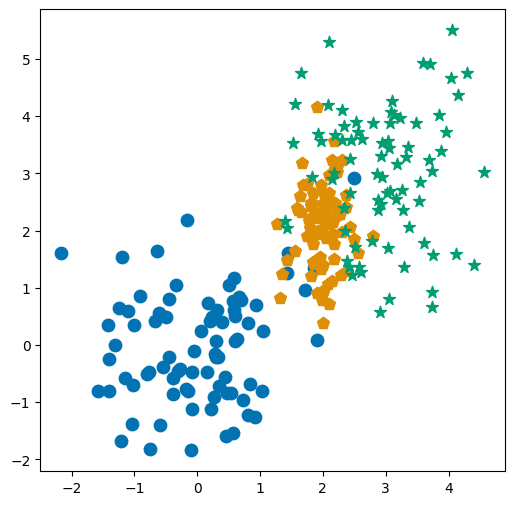

In [57]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.  
 
 **Answer** : Cette fonction renvoie, pour chaque valeur donnée par la régression, la classe correspondante, en effectuant l'arrondi à l'entier le plus proche. On distingue les cas où la valeur est négative et où l'arrondi est supérieur au nombre de classes en se ramenant au valeurs extrêmes.

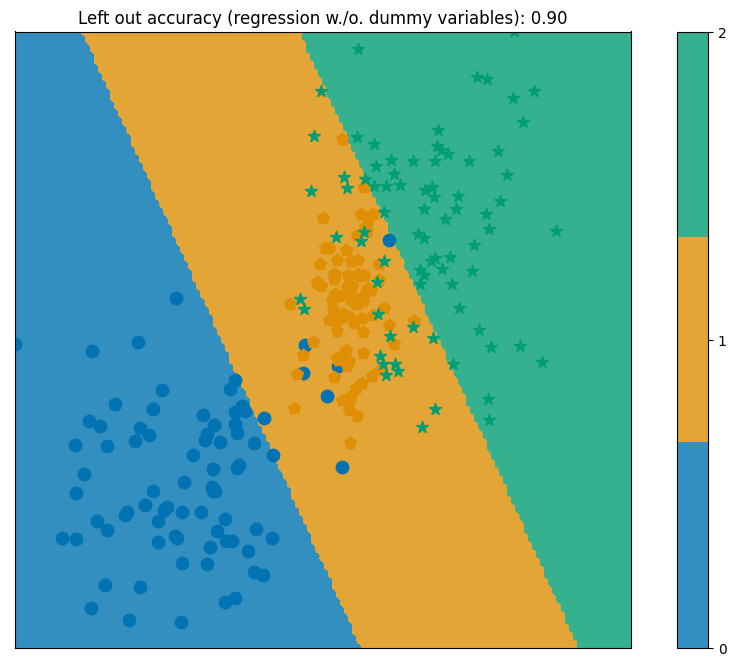

In [58]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

**Answer**: On observe cette fois un résultat de régression avec des lignes brisées, à la place des simples droites. Cette option donne des résultats meilleurs ou équivalents, puisqu'elle permet une plus grande liberté dans la façon d'établir les classes, en considérant plusieurs dimensions.

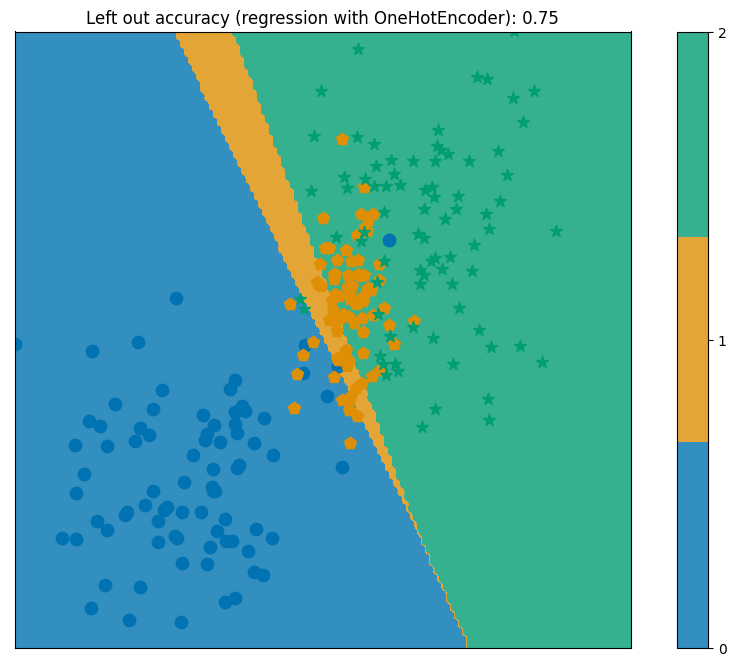

In [59]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150  
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

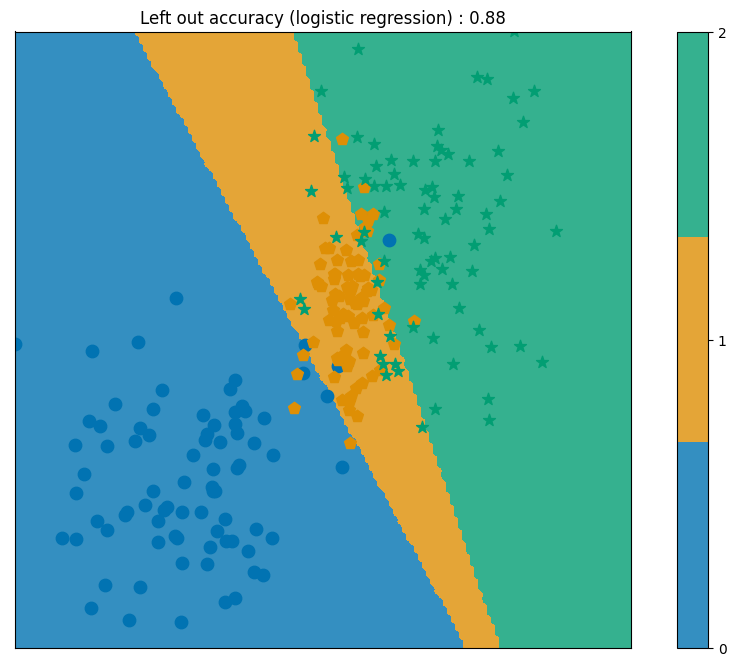

In [60]:
##############################################################################
# Logistic regression
##############################################################################


resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 

clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

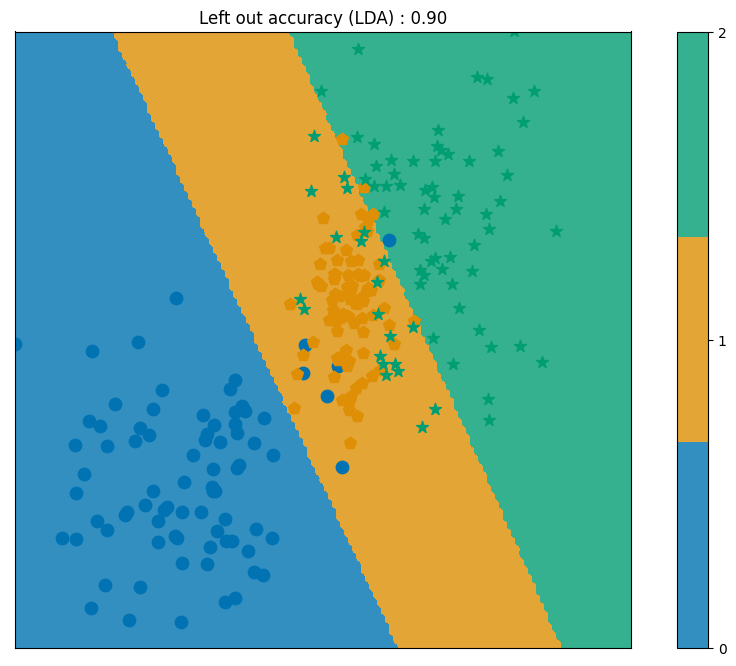

In [61]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150  
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

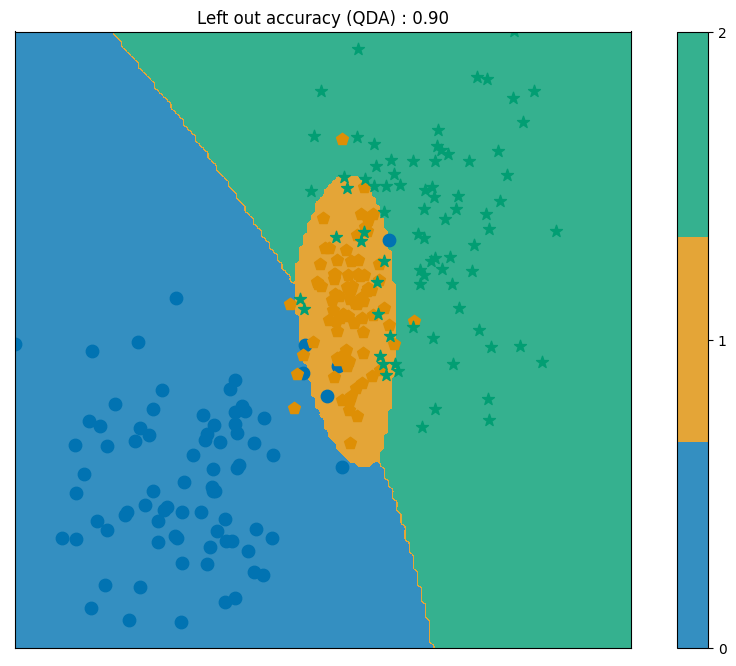

In [62]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

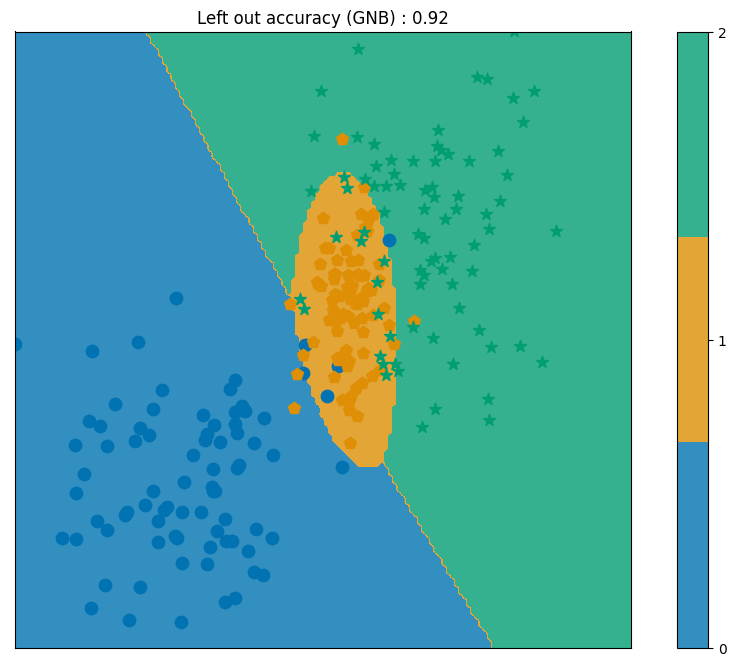

In [63]:
##############################################################################
# Naive Bayes 
##############################################################################
resolution_param = 150  
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)
y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

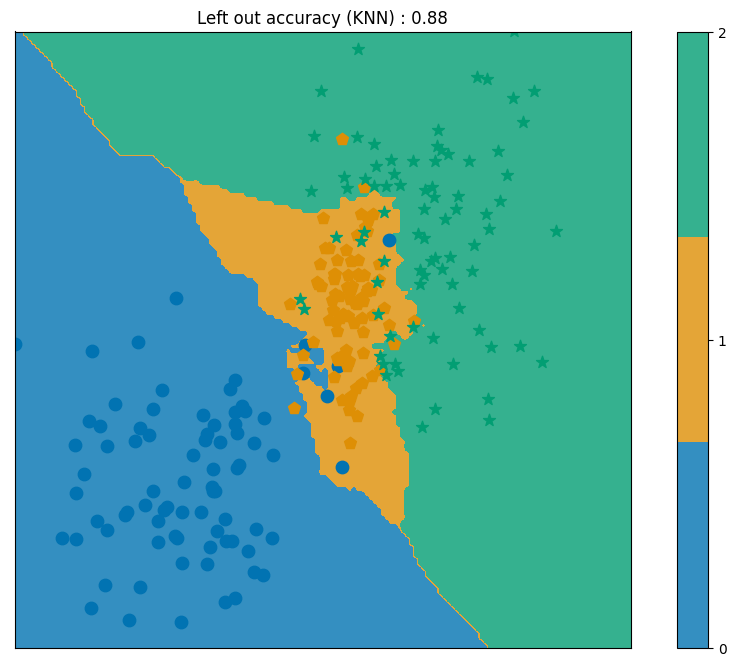

In [64]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?



**Answers**:  
- **Logistic regression** : Cette méthode est linéaire, puisqu'on travaille avec des probabilités elles-mêmes linéaires. On obtient en effet des lignes _droites_ brisées.  
- **Linear Discriminant analysis** : Cette méthode est évidemment linéaire aussi.
- **Quadratic discriminant analysis** : On a cette fois de façon évidente un modèle quadratique, et donc non linéaire : les délimitations sont des morceaux de paraboles.
- **Naives Bayes** : Cette méthode aussi est quadratique, mais les coefficients des paraboles sont différents.  
- **KNN** : Ce modèle est non linéaire mais les délimitations ne sont plus des paraboles : les régions de décision n'ont pas de structure particulière et dépendent juste du nombre de voisins considérés.  

On obtient plutôt des meilleurs résultats en terme de temps pour le _Naives Bayes_, et les temps de calculs affichés sont souvent trop faibles pour qu'ils présentent un intérêt, ce que je trouve curieux.

In [65]:
# example using Logistic regression
time_start = time.perf_counter()
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy', "%.2f" %accuracy_score(y_test, y_logit_test))

Computational time: 0.01 s ; Test accuracy 0.88


In [66]:
# example using LDA
time_start = time.perf_counter()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy', "%.2f" %accuracy_score(y_test, y_LDA_test))

Computational time: 0.00 s ; Test accuracy 0.90


In [67]:
# example using QDA
time_start = time.perf_counter()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_QDA_test))

Computational time: 0.00 s ; Test accuracy  0.90


In [68]:
# example using Naive Bayes
time_start = time.perf_counter()
clf_GNB.fit(X_train, y_train)
y_GNB_test = clf_GNB.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy', "%.2f" %accuracy_score(y_test, y_GNB_test))

Computational time: 0.00 s ; Test accuracy 0.92


In [69]:
# example using KNN
time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.00 s ; Test accuracy 0.88
